# Step 5: Prediction

---

## 1. Importing the necessary libraries and original test dataset

In [13]:
# Imports library for data manipulation and visualisation
import sys
sys.path.append("../utilities")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from color import color
import warnings
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.impute import KNNImputer
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



# ignore all warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [14]:
df_train = pd.read_csv("../dataset/processed_train.csv")
df_test = pd.read_csv("../dataset/processed_test.csv")
df_test_og = pd.read_csv("../dataset/data_test.csv")

In [15]:
df_test.shape

(50736, 21)

In [16]:
df_test_og.shape

(50736, 25)

We have the same row counts, so we can map the Id correctly after prediction.

## 2. Model Recreation

Classifier: random_forest

AUC: 0.98, F1: 0.91, Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 20}

We will re-run the same code in step 4 do produce the model for prediction with the best parameter as above

In [17]:
x = df_train.drop(["Status"], axis=1)
y = df_train[["Status"]]

# Splitting our training data into a train set and a validation set
x_train, x_val, y_train, y_val = train_test_split(
    x, y,
    shuffle=True,
    random_state=0,  # Ensure reproducible results
    test_size=0.2    # 80 - 20
)

print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}")
print(f"y_val: {y_val.shape}")

x_train: (106620, 20)
y_train: (106620, 1)
x_val: (26655, 20)
y_val: (26655, 1)


In [18]:
clfs_hyperpara = dict()
cross_val = KFold(n_splits=5, shuffle=True, random_state=0)

### 2.1 Setting Hyperparameters

In [19]:
hyper_para = {
    "n_estimators": np.arange(5, 25, 5),
    "max_depth": np.arange(2, 24, 2),
    "criterion": ['gini', 'entropy'],
    "max_features": ['auto', 'sqrt', 'log2'],
}

### 2.2 Random Forest Model

In [21]:
random_forest_clf = RandomForestClassifier(
    random_state=0     # Reproducible result
)

grid_clf = GridSearchCV(random_forest_clf, hyper_para, cv=cross_val, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True, n_jobs=-1)
grid_clf.fit(x_train, y_train.values.ravel())

y_train_pred = grid_clf.predict(x_train)
y_val_pred = grid_clf.predict(x_val)

Params with highest score: {'criterion': 'gini', 'max_depth': 22, 'max_features': 'auto', 'n_estimators': 20}
Params with best score and smallest gap: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 20}
Train score with best parameters: 0.9115044531987131
Validation score with best parameters: 0.9063374752542652


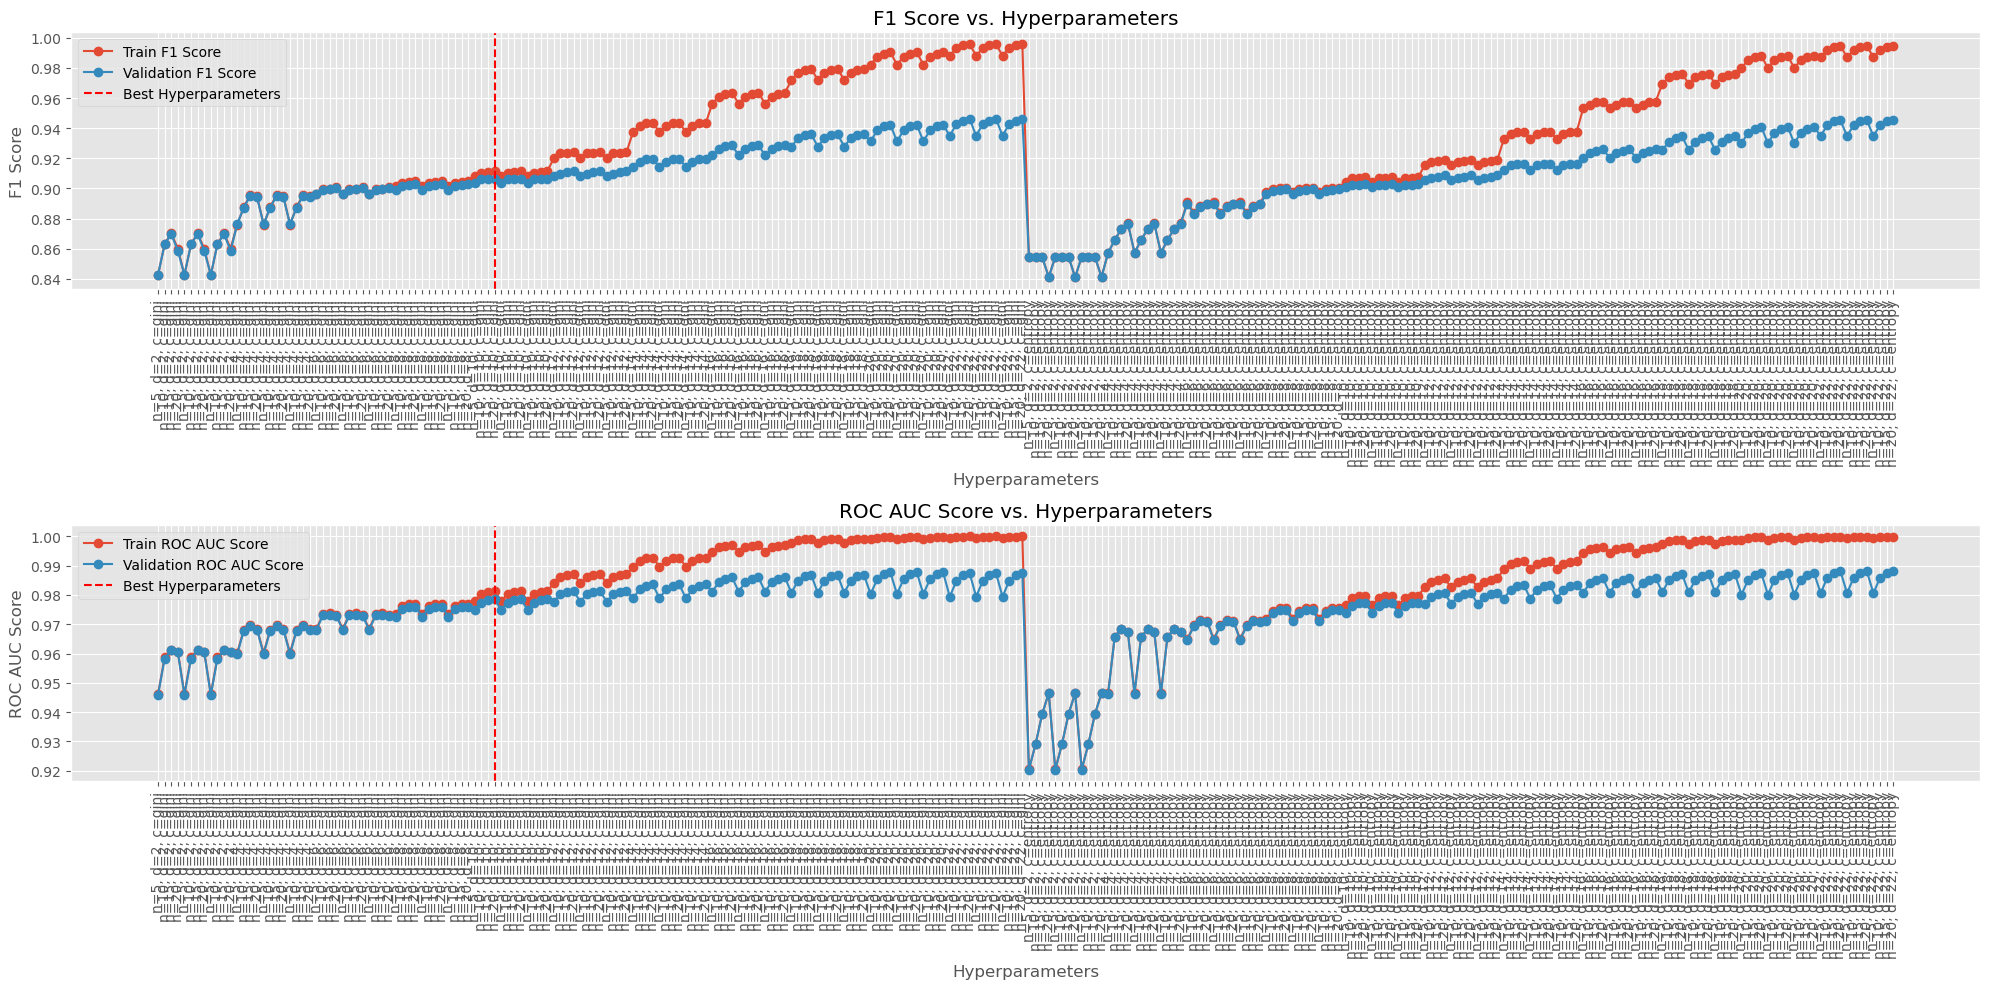

In [22]:
def visualize_cls(grid_clf):
    # Extracting the results from grid search
    train_f1_scores = grid_clf.cv_results_['mean_train_f1']
    val_f1_scores = grid_clf.cv_results_['mean_test_f1']
    train_roc_auc_scores = grid_clf.cv_results_['mean_train_roc_auc']
    val_roc_auc_scores = grid_clf.cv_results_['mean_test_roc_auc']
    hyper_params = grid_clf.cv_results_['params']

    # Calculate the absolute difference between train and validation scores
    score_diff = np.abs(train_f1_scores - val_f1_scores)

    # Define thresholds for score and gap
    score_threshold = 0.8  
    gap_threshold = 0.01 

    # Find the index where the validation score is above the threshold and gap is below the threshold
    candidate_indices = np.where((val_f1_scores > score_threshold) & (score_diff < gap_threshold))[0]

    # Choose the hyperparameters with the highest validation F1 score among the candidates
    best_index = candidate_indices[np.argmax(val_f1_scores[candidate_indices])]
    best_params = hyper_params[best_index]

    hyper_param_labels = [f"n={param['n_estimators']}, d={param['max_depth']}, c={param['criterion']}" for param in hyper_params]

    print("Params with highest score:", grid_clf.best_params_)
    print("Params with best score and smallest gap:", best_params)
    print("Train score with best parameters:", train_f1_scores[best_index])
    print("Validation score with best parameters:", val_f1_scores[best_index])
    
    clfs_hyperpara["random_forest"] = best_params

    # Plotting F1 scores
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(hyper_params)), train_f1_scores, label='Train F1 Score', marker='o')
    plt.plot(np.arange(len(hyper_params)), val_f1_scores, label='Validation F1 Score', marker='o')
    plt.xlabel('Hyperparameters')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Hyperparameters')
    plt.xticks(np.arange(len(hyper_params)), hyper_param_labels, rotation=90)
    plt.axvline(x=best_index, color='r', linestyle='--', label='Best Hyperparameters')
    plt.legend()

    # Plotting ROC AUC scores
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(hyper_params)), train_roc_auc_scores, label='Train ROC AUC Score', marker='o')
    plt.plot(np.arange(len(hyper_params)), val_roc_auc_scores, label='Validation ROC AUC Score', marker='o')
    plt.xlabel('Hyperparameters')
    plt.ylabel('ROC AUC Score')
    plt.title('ROC AUC Score vs. Hyperparameters')
    plt.xticks(np.arange(len(hyper_params)), hyper_param_labels, rotation=90)
    plt.axvline(x=best_index, color='r', linestyle='--', label='Best Hyperparameters')
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_cls(grid_clf)

In [23]:
for name, params in clfs_hyperpara.items():
    print(f"Classifier: {color.RED}{color.BOLD}{name}{color.END}")
    print(f"Hyperparameter: {color.RED}{color.BOLD}{params}{color.END}")
    if 'random_forest' in name:
        random_for_clf = RandomForestClassifier(**params)
        print("Chosen Random Forest Classifier")
    else:
        continue  # Skip unknown classifier
    
    # Train the classifier on the entire training dataset
    random_for_clf.fit(x_train, y_train)

Classifier: random_forest
Hyperparameter: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 20}
Chosen Random Forest Classifier


## 3. Prediction and Saving File

In [32]:
x = df_test.drop(["Status"], axis=1)
y = df_test[["Status"]]

y_predict_final = random_for_clf.predict(x)

df_test["Status"] = y_predict_final

df_test.to_csv("../dataset/full-predictions.csv", index=False)

df_export = df_test_og[["Id", "Status"]]

df_export["Status"] = y_predict_final

df_export.to_csv("../export/s3938278_predictions.csv", index=False)


In [26]:
df_test.shape

(50736, 21)

In [27]:
df_test.head

<bound method NDFrame.head of        HighBP  HighChol       BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0           1         1  0.460527       1       0                     1   
1           0         0 -0.047410       1       0                     0   
2           0         0 -1.457965       0       0                     0   
3           0         0 -0.671356       1       0                     0   
4           1         0  1.008068       0       0                     0   
...       ...       ...       ...     ...     ...                   ...   
50731       1         0  1.448396       0       0                     0   
50732       0         1 -0.671356       0       0                     0   
50733       1         1  0.609607       0       0                     1   
50734       1         1 -0.671356       1       0                     0   
50735       1         0 -1.173807       0       0                     0   

       PhysActivity  Fruits  Veggies  HvyAlcoholConsump  ...   GenHlt

In [30]:
df_export.shape

(50736, 2)

In [31]:
df_export.head

<bound method NDFrame.head of            Id  Status
0      202944       0
1      202945       0
2      202946       1
3      202947       0
4      202948       0
...       ...     ...
50731  253675       0
50732  253676       0
50733  253677       1
50734  253678       1
50735  253679       0

[50736 rows x 2 columns]>

Checking if the exported file is in correct format

In [35]:
df1 = pd.read_csv('../export/s3938278_predictions.csv')
df2 = pd.read_csv('../dataset/s1234567_predictions.csv')

# Extract the first columns from both DataFrames
column1_file1 = df1.iloc[:, 0]
column1_file2 = df2.iloc[:, 0]

# Check if the first columns are identical
if column1_file1.equals(column1_file2):
    print("The first columns in the two files are identical.")
else:
    print("The first columns in the two files are not identical.")

The first columns in the two files are identical.
